# ⛩ push to github

In [290]:
#%%capture
import os
from google.colab import drive
from google.colab import userdata
drive.mount('/content/drive',
            force_remount=True
            )


notebookname = 'SEO.ipynb'

class github:
    def __init__(self, github_pat, github_email, github_username, github_repo, gdrive_notebook_folder, notebook_name):
        self.github_pat = userdata.get(github_pat)
        self.github_email = userdata.get(github_email)
        self.github_username = userdata.get(github_username)
        self.github_repo = userdata.get(github_repo)
        self.gdrive_notebook_folder = userdata.get(gdrive_notebook_folder)
        self.notebook_name = notebook_name

    def clone_repo(self):
        # Source file path in Google Drive
        source_file_path = f"/content/drive/MyDrive/{self.gdrive_notebook_folder}/{self.notebook_name}"

        # Repository details
        repo_url = f'https://{self.github_pat}@github.com/{self.github_username}/{self.github_repo}.git'

        # Clone the private repository
        !git clone {repo_url} cloned-repo
        os.chdir('cloned-repo')  # Switch to the cloned repository

        # Ensure the file exists in Google Drive
        if os.path.exists(source_file_path):
            # Copy the notebook into the cloned repository
            !cp "{source_file_path}" ./
        else:
            print(f"The file {source_file_path} was not found.")
            return  # Exit if the file doesn't exist

        # Git configuration
        !git config user.email "{self.github_email}"
        !git config user.name "{self.github_username}"

        # Add the file to Git
        !git add "{self.notebook_name}"

        # Commit the changes
        !git commit -m "Added {self.notebook_name} from Google Drive"

        # Push to the repository
        !git push origin main

        # Wechsle zurück ins übergeordnete Verzeichnis und lösche cloned-repo
        os.chdir('..')
        !rm -rf cloned-repo
        print("cloned-repo wurde wieder gelöscht.")



# Clone, add, and push the notebook
clone_2 = github('github_pat', 'github_email', 'github_username', 'github_repo_seo', 'gdrive_seo_folder', notebookname)
clone_2.clone_repo()


Mounted at /content/drive
Cloning into 'cloned-repo'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 168 (delta 4), reused 15 (delta 4), pack-reused 153 (from 1)
Receiving objects: 100% (168/168), 2.10 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (48/48), done.
[main a006ceb] Added SEO.ipynb from Google Drive
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite SEO.ipynb (89%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 14.05 KiB | 958.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/MarkH0705/SEO_Analyses.git
   c6e3a78..a006ceb  main -> main
cloned-repo wurde wieder gelöscht.


# 🕸 scrap

In [218]:
import os
import requests
from bs4 import BeautifulSoup, Comment
from urllib.parse import urljoin, urlparse
import chardet


class WebsiteScraper:
    """
    Diese Klasse kümmert sich ausschließlich um das Sammeln und Extrahieren
    von Texten aus einer Website.
    """

    def __init__(self, start_url="https://www.rue-zahnspange.de", max_pages=50):
        """
        :param start_url: Die Start-URL der Website, z.B. "https://www.example.com"
        :param max_pages: Maximale Anzahl Seiten, die gecrawlt werden.
        """
        self.start_url = start_url
        self.max_pages = max_pages

        # Hier speichern wir {URL: reiner_Text}
        self.scraped_data = {}

    def scrape_website(self):
        """
        Startet den Crawl-Vorgang, gefolgt von der Extraktion des Textes
        und dem Sammeln interner Links.
        """
        visited = set()
        to_visit = [self.start_url]
        domain = urlparse(self.start_url).netloc

        while to_visit and len(visited) < self.max_pages:
            url = to_visit.pop(0)
            if url in visited:
                continue
            visited.add(url)

            try:
                response = requests.get(url, timeout=10)

                # Rohdaten holen und Encoding per chardet bestimmen
                raw_data = response.content
                detected = chardet.detect(raw_data)
                encoding = "utf-8"
                text_data = raw_data.decode(encoding, errors="replace")

                # Nur weiterverarbeiten, wenn HTML-Content
                if (response.status_code == 200
                        and "text/html" in response.headers.get("Content-Type", "")):
                    soup = BeautifulSoup(text_data, "html.parser")

                    # Text extrahieren
                    text = self._extract_text_from_soup(soup)
                    self.scraped_data[url] = text

                    # Interne Links sammeln
                    for link in soup.find_all("a", href=True):
                        absolute_link = urljoin(url, link["href"])
                        if urlparse(absolute_link).netloc == domain:
                            if (absolute_link not in visited
                                    and absolute_link not in to_visit):
                                to_visit.append(absolute_link)

            except requests.RequestException as e:
                print(f"Fehler beim Abrufen von {url}:\n{e}")

    def _extract_text_from_soup(self, soup):
        """
        Extrahiert aus <p>, <h1>, <h2>, <h3>, <li> reinen Text,
        entfernt Script-/Style-/Noscript-Tags und Kommentare.
        """
        for script_or_style in soup(["script", "style", "noscript"]):
            script_or_style.decompose()

        for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
            comment.extract()

        texts = []
        for tag in soup.find_all(["p", "h1", "h2", "h3", "li", "faq4_question", "faq4_answer"]):
            txt = tag.get_text(strip=True)
            if txt:
                texts.append(txt)

        return "\n".join(texts)




    def _extract_text_from_soup(self, soup):
        """
        Extrahiert aus <p>, <h1>, <h2>, <h3>, <li> reinen Text,
        aber NICHT die, die in .faq4_question oder .faq4_answer stecken.
        Außerdem extrahiert er separat die FAQ-Fragen und -Antworten
        (faq4_question / faq4_answer).
        """
        # 1) Script/Style entfernen
        for script_or_style in soup(["script", "style", "noscript"]):
            script_or_style.decompose()

        # 2) Kommentare entfernen
        from bs4 import Comment
        for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
            comment.extract()

        # 3) Normale Texte (p, h1, h2, h3, li), ABER nicht innerhalb von .faq4_question / .faq4_answer
        texts = []
        all_normal_tags = soup.find_all(["p", "h1", "h2", "h3", "li"])
        for tag in all_normal_tags:
            # Prüfen, ob das Tag einen Vorfahren (Parent) hat mit Klasse faq4_question oder faq4_answer
            # Wenn ja, ignorieren wir es
            if tag.find_parent(class_="faq4_question") or tag.find_parent(class_="faq4_answer"):
                continue

            txt = tag.get_text(strip=True)
            if txt:
                texts.append(txt)

        # 4) FAQ-Bereiche (Fragen + Antworten)
        #    a) Alle Frage-Elemente mit Klasse .faq4_question
        #    b) Alle Antwort-Elemente mit Klasse .faq4_answer
        #    Wir gehen davon aus, dass Frage i zum Antwort i passt.

        questions = soup.select(".faq4_question")
        answers = soup.select(".faq4_answer")

        # 5) Zusammenführen (Frage + Antwort)
        for q, a in zip(questions, answers):
            q_text = q.get_text(strip=True)
            a_text = a.get_text(strip=True)
            if q_text and a_text:
                combined = f"Frage: {q_text}\nAntwort: {a_text}"
                texts.append(combined)

        # 6) Als String zurückgeben
        return "\n".join(texts)





    def get_scraped_data(self):
        """
        Gibt das Dictionary {URL: Text} zurück.
        Du kannst damit arbeiten, Seiten filtern, etc.
        """
        return self.scraped_data


In [291]:
import os
import requests
from bs4 import BeautifulSoup, Comment
from urllib.parse import urljoin, urlparse
import chardet

class WebsiteScraper:
    """
    Diese Klasse kümmert sich ausschließlich um das Sammeln und Extrahieren
    von Texten aus einer Website.
    """

    def __init__(self, start_url="https://www.rue-zahnspange.de", max_pages=50):
        """
        :param start_url: Die Start-URL der Website, z.B. "https://www.example.com"
        :param max_pages: Maximale Anzahl Seiten, die gecrawlt werden.
        """
        self.start_url = start_url
        self.max_pages = max_pages

        # Hier speichern wir {URL: reiner_Text}
        self.scraped_data = {}

    def scrape_website(self):
        """
        Startet den Crawl-Vorgang, gefolgt von der Extraktion des Textes
        und dem Sammeln interner Links.
        """
        visited = set()
        to_visit = [self.start_url]
        domain = urlparse(self.start_url).netloc

        while to_visit and len(visited) < self.max_pages:
            url = to_visit.pop(0)
            if url in visited:
                continue
            visited.add(url)

            try:
                response = requests.get(url, timeout=10)

                # Rohdaten holen und Encoding per chardet bestimmen
                raw_data = response.content
                detected = chardet.detect(raw_data)
                # Wenn chardet etwas erkennt, nehmen wir das. Sonst Standard "utf-8".
                encoding = "utf-8"
                text_data = raw_data.decode(encoding, errors="replace")

                # Nur weiterverarbeiten, wenn HTML-Content
                if (response.status_code == 200
                    and "text/html" in response.headers.get("Content-Type", "")):
                    soup = BeautifulSoup(text_data, "html.parser")

                    # Text extrahieren
                    text = self._extract_text_from_soup(soup)
                    self.scraped_data[url] = text

                    # Interne Links sammeln
                    for link in soup.find_all("a", href=True):
                        absolute_link = urljoin(url, link["href"])
                        if urlparse(absolute_link).netloc == domain:
                            if (absolute_link not in visited
                                and absolute_link not in to_visit):
                                to_visit.append(absolute_link)

            except requests.RequestException as e:
                print(f"Fehler beim Abrufen von {url}:\n{e}")

    def _extract_text_from_soup(self, soup):
        """
        Extrahiert aus <p>, <h1>, <h2>, <h3>, <li> reinen Text,
        aber NICHT die, die in .faq4_question oder .faq4_answer stecken.
        Außerdem extrahiert er separat die FAQ-Fragen und -Antworten
        (faq4_question / faq4_answer), damit wir beide Zeilenumbrüche
        dort ebenfalls erhalten.
        """

        # 1) Script/Style/Noscript entfernen
        for script_or_style in soup(["script", "style", "noscript"]):
            script_or_style.decompose()

        # 2) Kommentare entfernen
        for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
            comment.extract()

        # 3) Normale Texte (p, h1, h2, h3, li), ABER nicht innerhalb von .faq4_question / .faq4_answer
        texts = []
        all_normal_tags = soup.find_all(["p", "h1", "h2", "h3", "li"])
        for tag in all_normal_tags:
            # Prüfen, ob das Tag einen Vorfahren hat mit Klasse faq4_question oder faq4_answer
            if tag.find_parent(class_="faq4_question") or tag.find_parent(class_="faq4_answer"):
                continue

            # Hier wichtig: separator="\n", strip=False, damit wir Zeilenumbrüche behalten
            txt = tag.get_text(separator="\n", strip=False)
            # Evtl. willst du doppelte Leerzeilen bereinigen. Das kannst du optional tun.
            if txt.strip():
                texts.append(txt.strip("\r\n"))

        # 4) FAQ-Bereiche (Fragen + Antworten)
        questions = soup.select(".faq4_question")
        answers = soup.select(".faq4_answer")

        # 5) Zusammenführen (Frage + Antwort)
        for q, a in zip(questions, answers):
            q_text = q.get_text(separator="\n", strip=False)
            a_text = a.get_text(separator="\n", strip=False)
            q_text = q_text.strip("\r\n")
            a_text = a_text.strip("\r\n")
            if q_text and a_text:
                combined = f"Frage: {q_text}\nAntwort: {a_text}"
                texts.append(combined)

        # 6) Als String zurückgeben. Wir trennen die einzelnen Elemente durch "\n\n"
        #    (kannst du je nach Wunsch anpassen)
        return "\n\n".join(texts)

    def get_scraped_data(self):
        """
        Gibt das Dictionary {URL: Text} zurück.
        Du kannst damit arbeiten, Seiten filtern, etc.
        """
        return self.scraped_data


# 📊SEO Analysis

In [292]:
pip install git+https://github.com/sethblack/python-seo-analyzer.git

  Cloning https://github.com/sethblack/python-seo-analyzer.git to /tmp/pip-req-build-e7mt4q2e
  Running command git clone --filter=blob:none --quiet https://github.com/sethblack/python-seo-analyzer.git /tmp/pip-req-build-e7mt4q2e
  Resolved https://github.com/sethblack/python-seo-analyzer.git to commit cfb38f5b39803ec1dc597158c9226ecd9bc07511
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [293]:
pip install langchain_anthropic

In [294]:
pip install python-dotenv

In [295]:
import dotenv
from pyseoanalyzer import analyze


url = "https://www.rue-zahnspange.de"
report = analyze(url)

# 'report' enthält nun sämtliche Analyseergebnisse
print(report)


Error occurred during crawling: object of type 'NoneType' has no len()
{'pages': [{'url': 'https://www.rue-zahnspange.de', 'title': 'Kieferorthopädie Essen – Dr. Leila Graf – Zahnspangen für Kinder & Erwachsene', 'description': 'Entdecken Sie moderne Zahnspangen für Kinder, Jugendliche und Erwachsene in Rüttenscheid ✅ Vereinbaren Sie jetzt einen Termin für Ihr neues Lächeln 🤩', 'author': None, 'hostname': 'rue-zahnspange.de', 'sitename': 'Kieferorthopädie Essen – Dr. Leila Graf', 'date': '2023-01-01', 'word_count': 1194, 'keywords': [(51, 'und'), (36, 'zu'), (33, 'die'), (18, 'der'), (17, 'lächeln'), (17, 'ein'), (16, 'für'), (15, 'wir'), (15, 'website'), (15, 'sie'), (15, 'prod'), (15, 'jpg'), (15, 'ist'), (15, 'https'), (15, 'files'), (15, 'com'), (15, 'cdn'), (15, '6566076ab3f5b7a2f147da0d'), (14, 'eine'), (12, 'um'), (11, 'auf'), (10, 'mit'), (10, 'behandlung'), (9, 'zahnspange'), (8, 'graf'), (7, 'zähne'), (7, 'von'), (7, 'sind'), (7, 'ihre'), (7, 'dr'), (7, 'bei'), (7, '20titel')

<ipython-input-296-663c6ccb123c>:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


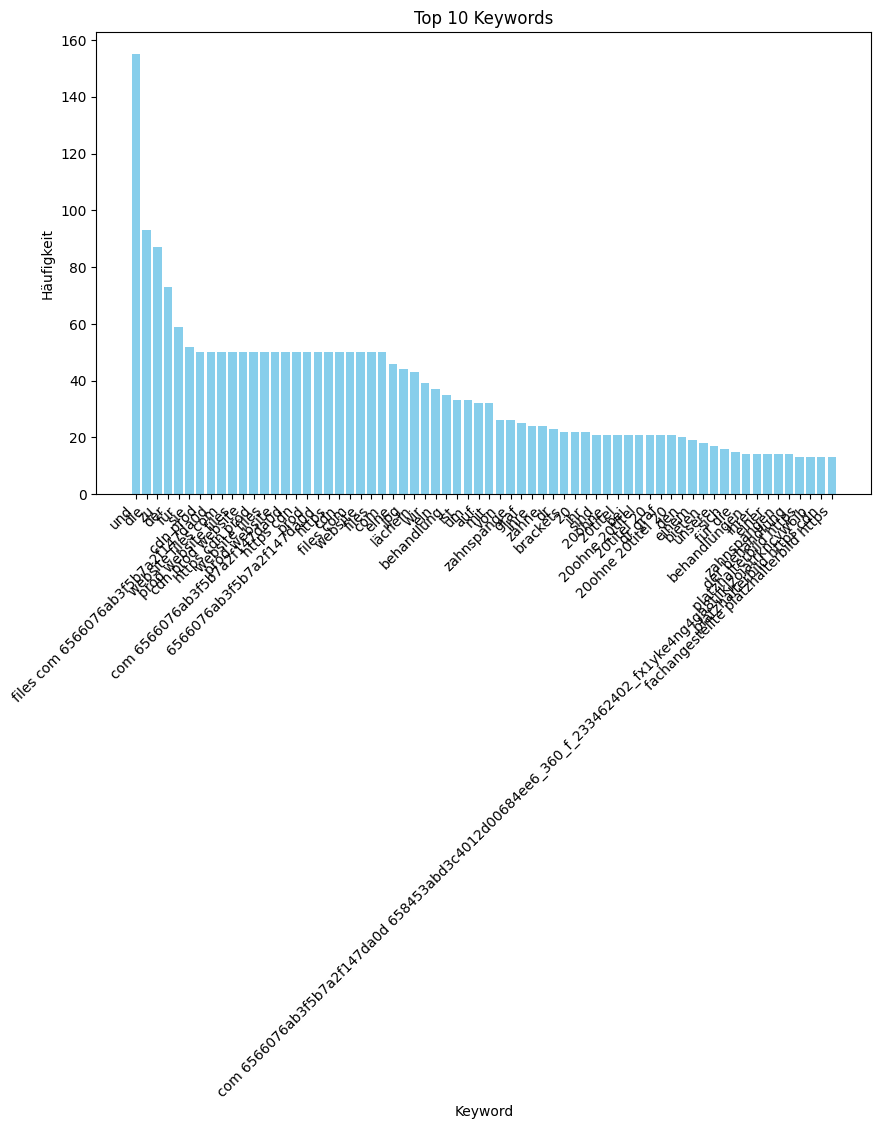

In [296]:
import pandas as pd
import matplotlib.pyplot as plt

# Beispiel: Wir holen uns das Keyword-Dictionary
keywords_dict = report.get("keywords", {})

# Wenn es tatsächlich ein dict ist: {"keyword1": count, "keyword2": count, ...}
df_keywords = pd.DataFrame(keywords_dict)

# Sortieren nach Häufigkeit absteigend
df_keywords.sort_values("count", ascending=False, inplace=True)

# Nur die Top 10 Keywords anzeigen
df_top10 = df_keywords.head(66)

# Einfaches Balkendiagramm
plt.figure(figsize=(10, 6))
plt.bar(df_top10['word'], df_top10["count"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Keywords")
plt.xlabel("Keyword")
plt.ylabel("Häufigkeit")
plt.tight_layout()
plt.show()


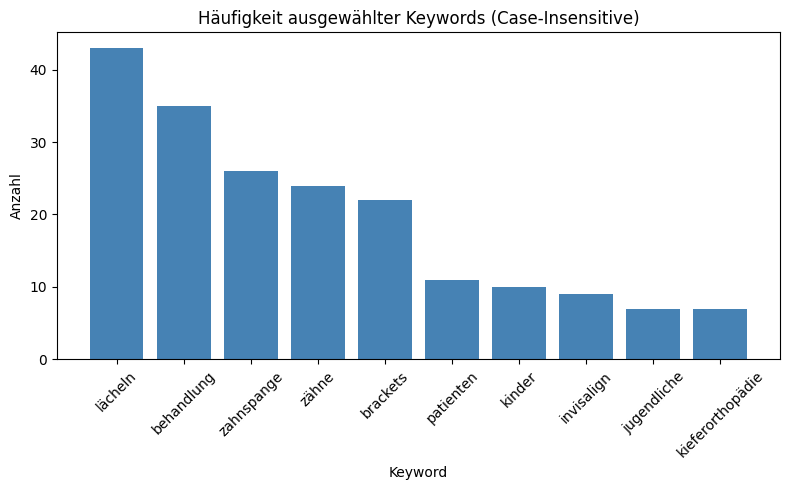

In [297]:
import matplotlib.pyplot as plt


# Beispiel: Wir holen uns das Keyword-Dictionary
keywords_dict = report.get("keywords", {})

# Wenn es tatsächlich ein dict ist: {"keyword1": count, "keyword2": count, ...}
df_keywords = pd.DataFrame(keywords_dict)

# Neue Spalte mit Kleinbuchstaben erzeugen
df_keywords["word_lower"] = df_keywords["word"].str.lower()

# Die Keywords, nach denen du suchen möchtest (Case-insensitive)
interesting_keywords = ["zahnspange", "Invisalign", "kieferorthopädie", "BEHANDLUNG", "Kosten" , "zähne", "brackets", "Unsichtbar", "Kinder", "Jugendliche", "Patienten", "lächeln"]
# Auch diese in Kleinbuchstaben umwandeln
interesting_keywords_lower = [kw.lower() for kw in interesting_keywords]

# DataFrame nach den gewünschten Keywords filtern (Case-insensitive)
df_subset = df_keywords.loc[df_keywords["word_lower"].isin(interesting_keywords_lower)].copy()

# Sortieren nach Häufigkeit, damit das Diagramm übersichtlicher wird
df_subset.sort_values("count", ascending=False, inplace=True)

# Balkendiagramm
plt.figure(figsize=(8, 5))
# Plotten kannst du z.B. weiterhin den Originalwert "word" (falls du im Diagramm
# die ursprüngliche Schreibweise sehen willst)
plt.bar(df_subset["word"], df_subset["count"], color="steelblue")
plt.title("Häufigkeit ausgewählter Keywords (Case-Insensitive)")
plt.xlabel("Keyword")
plt.ylabel("Anzahl")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

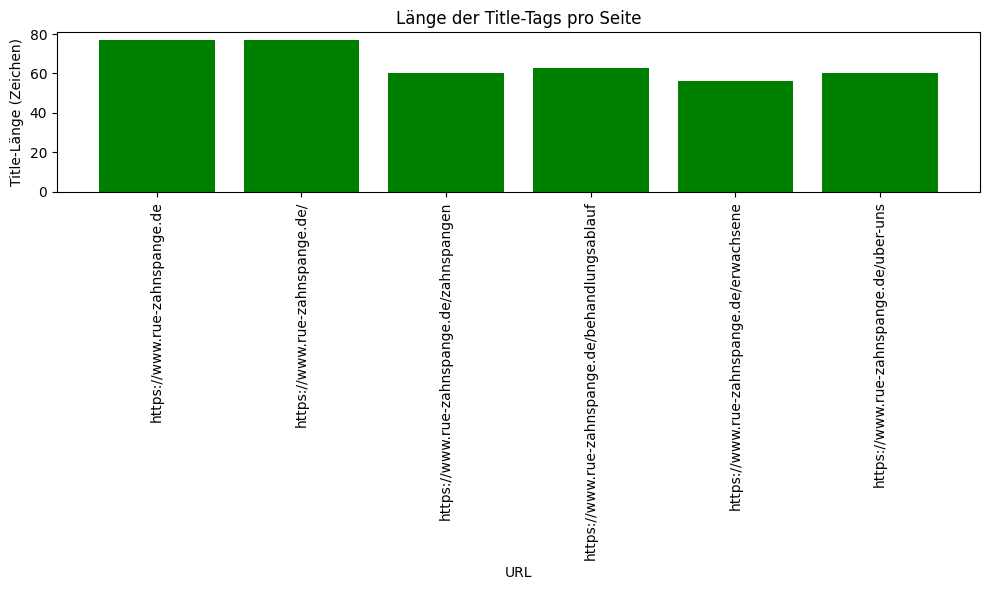

In [298]:
pages = report.get("pages", [])

df_pages = pd.DataFrame(pages)

# Beispiel: Title-Länge berechnen
df_pages["title_length"] = df_pages["title"].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Balkendiagramm Title-Länge
plt.figure(figsize=(10, 6))
plt.bar(df_pages["url"], df_pages["title_length"], color="green")
plt.xticks(rotation=90)
plt.title("Länge der Title-Tags pro Seite")
plt.xlabel("URL")
plt.ylabel("Title-Länge (Zeichen)")
plt.tight_layout()
plt.show()


<ipython-input-299-f71e74ebdef3>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(df_top10["word"], rotation=45, ha="right")
<ipython-input-299-f71e74ebdef3>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_pages["url"], rotation=90)


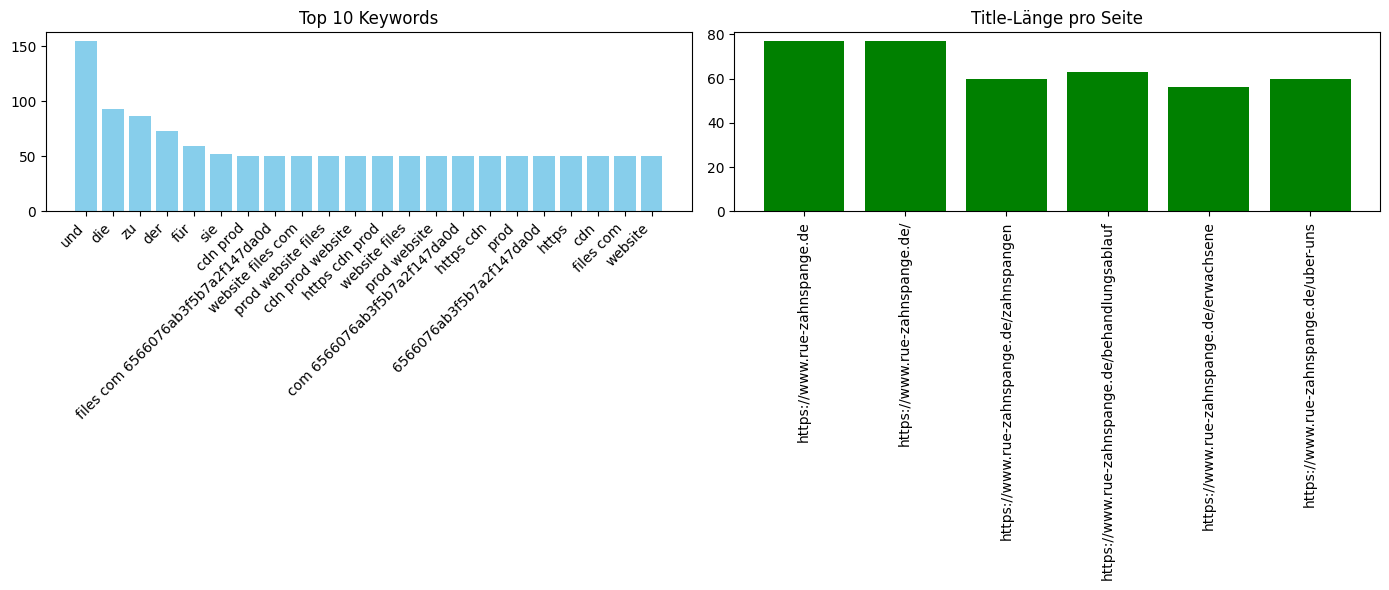

In [299]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 Zeile, 2 Spalten

# (a) Keywords
axes[0].bar(df_top10["word"].head(22), df_top10["count"].head(22), color="skyblue")
axes[0].set_title("Top 10 Keywords")
axes[0].set_xticklabels(df_top10["word"], rotation=45, ha="right")

# (b) Title-Längen
axes[1].bar(df_pages["url"], df_pages["title_length"], color="green")
axes[1].set_title("Title-Länge pro Seite")
axes[1].set_xticklabels(df_pages["url"], rotation=90)

plt.tight_layout()
plt.show()


# 🤖 chatbot

In [300]:
import openai
import time
os.environ['OPENAI_API_KEY'] = userdata.get('open_ai_api_key')

class Chatbot:
    """
    Diese Chatbot-Klasse nutzt die neue Methode client.chat.completions.create()
    aus openai>=1.0.0 über openai.OpenAI().
    """

    def __init__(self, systemprompt, prompt):
        self.client = openai.OpenAI(api_key=os.environ['OPENAI_API_KEY'])
        self.systemprompt = systemprompt
        self.prompt = prompt
        self.context = [{"role": "system", "content": systemprompt}]
        self.model = "gpt-4o-mini-2024-07-18"

    def chat(self):
        """
        Sendet den Prompt an das Chat-Interface und gibt den kompletten Antwort-String zurück.
        """
        self.context.append({"role": "user", "content": self.prompt})
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=self.context
            )
            response_content = response.choices[0].message.content
            self.context.append({"role": "assistant", "content": response_content})
            return response_content
        except Exception as e:
            print(f"Fehler bei der OpenAI-Anfrage: {e}")
            return ""


    def chat_with_streaming(self):
            """
            Interagiert mit OpenAI Chat Completion API und streamt die Antwort.
            """
            # Nachricht zur Konversation hinzufügen
            self.context.append({"role": "user", "content": self.prompt})


            try:
                # Streaming-Option aktivieren
                response = self.client.chat.completions.create(
                    model=self.model,
                    messages=self.context,
                    stream=True
                )

                streamed_content = ""  # Zum Speichern der gestreamten Antwort

                for chunk in response:
                    # Debugging: Anzeigen, was tatsächlich in jedem Chunk enthalten ist
                    delta = chunk.choices[0].delta
                    content = getattr(delta, "content", "")

                    if content:  # Verarbeite nur nicht-leere Inhalte
                        print(content, end="", flush=True)
                        streamed_content += content

                print()  # Neue Zeile am Ende

                # Gestreamte Antwort zur Konversation hinzufügen
                self.context.append({"role": "assistant", "content": streamed_content})

                # Return the streamed content
                return streamed_content # This line was added

            except Exception as e:
                print(f"\nDEBUG: An error occurred during streaming: {e}")
                # Return empty string in case of error
                return "" # This line was added


# 🆎 NLP

In [301]:
def chunk_text(text, max_tokens=10000):
    """
    Teilt den Text in Blöcke auf, damit er nicht zu lang
    für die OpenAI-API wird.
    Hier sehr vereinfacht: 1 Token ~ 4 Zeichen.
    """
    chunks = []
    approx_char_limit = max_tokens * 4
    start = 0
    while start < len(text):
        end = start + approx_char_limit
        chunk = text[start:end]
        chunks.append(chunk)
        start = end
    return chunks


# 🔮keywords + Stadt

In [302]:
systemprompt_keywords = ("""
    Du bist ein intelligentes KI-System, das auf die Generierung von SEO-Keywords spezialisiert ist.
    Der Benutzer wird dir den kompletten Text von einer gescrapten website aus einem webcrawler vorgeben.
    Deine Aufgabe ist es, den Text zu interpretieren und eine Liste von SEO-Keywords basierend auf diesem Input zu erstellen.
    Du sollst zu dem Text passende SEO-Keywords finden. Auf Basis dieser keywords soll später der Text optimiert werden.
    Stelle sicher, dass die Keywords:

    Thematisch relevant sind,
    Hohe Suchintention abdecken (Short-Tail und Long-Tail Keywords),
    Varianten mit Synonymen oder verwandten Begriffen enthalten,
    Erschaffe Keywords, die lokale Ausrichtung enthalten. Das Unternehmen der webesite befindet sich in Essen-Rüttenscheid, im Ruhrgebiet, im Essener Süden.


    Struktur für die Antwort:

    Erstelle eine serialisierte Liste von SEO-Keywords.

    Beispiel für eine User-Eingabe:

    "SuperFood, ein Geschäft in Köln-Kalk für gesunde Ernährung für Sportler. Ein Sportler muss auf seine Ernährung ganz besonders achten."
    Beispiel für eine Ausgabe:



    [Köln-Kalk, gesund, SuperFood, Ernährung, Sportler, Ernährungstipps, Sporternährung Rezepte, Fitness, Sport]


    Beispiel für eine User-Eingabe:

    "Dr.med. Wurst, Ihr Arzt für Allgemeinmedizin in Heilbronn. Wir haben Impfungen und Tabletten gegen alle Krankheiten und Schnupfen."
    Beispiel für eine Ausgabe:



    [Heilbronn, Dr.med. Wurst, krank, Allgemeinmedizin, Impfung, Medizin, Erkältungen, Krankenschein, Blutdruck, Diabetes]



""")


def user_prompt_keywords(text):
   return f"""
          Du bist online Marketing Experte und arbeitest für ein erfolgreiches Unternehemen mit SEO.

          Deine Aufgabe ist es, thematisch relevante, serialisierte SEO-Keywords zu erstellen, die sowohl Short-Tail als auch Long-Tail Keywords enthalten.
          Achte darauf, dass die Keywords Synonyme und verwandte Begriffe berücksichtigen, sowie lokale Informationen, und für Suchmaschinenoptimierung geeignet sind.


          Bitte generiere SEO-Keywords für den folgenden Text:

          {text}


          Strukturiere deine Antwort folgendermaßen:
          Gib eine Liste von Keywords in python zurück. Gebe sonst nichts zurück, keine EInleitung, keine Überschrift, keine Zusammenfassung,
          nichts ausser der Liste in python.


          Danke! Mein Job hängt davon ab!
          """


In [303]:
page_text_list = []
def prep_text_and_get_keywords():
    start_url = "https://www.rue-zahnspange.de/"
    scraper = WebsiteScraper(start_url=start_url, max_pages=20)
    scraper.scrape_website()
    scraped_data = scraper.get_scraped_data()

    EXCLUDED_KEYWORDS = ["impressum", "datenschutz", "agb"]
    filtered_urls = []


    # Alle URLs sammeln, die KEINEN der ausgeschlossenen Begriffe enthalten
    for url in scraped_data.keys():
        # Schauen, ob einer der EXCLUDED_KEYWORDS im URL-String (kleingeschrieben) vorkommt
        if any(keyword in url.lower() for keyword in EXCLUDED_KEYWORDS):
            # Falls ja, überspringen wir diese URL
            continue
        # Sonst nehmen wir sie auf
        filtered_urls.append(url)

        # 3. SEO-Analyse starten (für gefilterte Seiten)
    for url in filtered_urls:
        # Die gesamte Seite analysieren
        page_text = scraped_data[url]
        page_text_list.append(page_text)



    keyword_list =[]
    for text in page_text_list:

      cb = Chatbot(systemprompt_keywords, user_prompt_keywords(text))

      keyword_list.append(cb.chat())

    return keyword_list


In [304]:
keywords_raw = prep_text_and_get_keywords()

In [305]:
cb = Chatbot("Du bist eine intelligente Suchmaschine und willst dem user helfen!", f"""Sei ein online marketing spezialist mit einem Talent für SEO. Du analysierst Texte
und erstellst SEO-Keywords für ein international erfolgreiches Unternehmen.
Das hier ist roher Text mit SEO keywords, der von einer website gescrapt wurde.
Anlysiere diesen Text und extrahiere die wesentlichen 20 SEO-keywords.
{keywords_raw} Gebe nur die SEO keywords als Liste zurück, sonst nichts. Keine Einleitung, keine Zusammenfassung, nur die Liste wie zB [keywort_1, keywort_2]
""")
keywords_final = cb.chat()

In [306]:
cb = Chatbot("Du bist eine intelligente Suchmaschine und willst dem user helfen!"
, f"""Sei ein Experte für Textanalyse und Geographie. Du hast eine Liebe fürs Detail und deine Kollegen lieben dich für deinen scharfen Blick für Wörter.
Deine Aufgabe ist es, riesige Textmengen zu anlysieren und die Stadt und den Ortsteil zu finden, die in dem Text versteckt sind. Die Namen von Stadt und Stadtteil können auch in zB Strassennamen versteckt sein oder in den Namen
von anderen signifikanten Dingen in der Umgebung des Unternehmens.
Es sind Texte von einem website scrap eines Unternehmens. Es können mehr als ein Städtenamen auftauchen.
Deine Aufgabe ist es, den relevanten Städtenamen zu finden. Außerdem kann der Name des Stadtteils vorhanden sein, in dem das Unternehmen angesiedelt ist. Suche den auch!
Hier ist der Text:

{page_text_list}

Gebe nun den Namen der relevanten Stadt und des Stadtteils zurück. Gebe den Namen und den Stadtteil zurück, wie zB [Köln-Kalk] wenn der Stadtteil gefunden wurde oder zB [Münster], wenn kein Stadtteil gefunden wurde.
""")

stadt = cb.chat()

In [307]:
stadt

'[Essen]'

# 🔮 main SEO optimize

In [308]:
combined_analysis_list = []
filtered_urls = []

def main():
    # 1. SCRAPING
    start_url = "https://www.rue-zahnspange.de/"
    scraper = WebsiteScraper(start_url=start_url, max_pages=20)
    scraper.scrape_website()

    # Alle gescrapten Daten abrufen
    scraped_data = scraper.get_scraped_data()

    # 2. Sichten der Texte und Filtern
    #    Hier könntest du jetzt z. B. manuell prüfen, welche URLs wichtig sind.
    #    Wir geben einfach mal alle URLs aus:
    print("\n--- Gesammelte Seiten und Inhalte (gekürzt) ---")
    for url, text in scraped_data.items():
        print(f"\nURL: {url}")
        # Beispiel: Nur ersten 200 Zeichen zeigen
        print(f"Text: {text[:200]}...")




    EXCLUDED_KEYWORDS = ["impressum", "datenschutz", "agb"]

    # Alle URLs sammeln, die KEINEN der ausgeschlossenen Begriffe enthalten
    for url in scraped_data.keys():
        # Schauen, ob einer der EXCLUDED_KEYWORDS im URL-String (kleingeschrieben) vorkommt
        if any(keyword in url.lower() for keyword in EXCLUDED_KEYWORDS):
            # Falls ja, überspringen wir diese URL
            continue
        # Sonst nehmen wir sie auf
        filtered_urls.append(url)
        print(f"send text to LLM:  {url}")





    # 3. SEO-Analyse starten (für gefilterte Seiten)
    for url in filtered_urls:
        # Die gesamte Seite analysieren
        page_text = scraped_data[url]

        # 3.1 Chunken, um zu große Anfragen zu vermeiden
        text_chunks = chunk_text(page_text, max_tokens=10000)

        print(f"\n=== Analyzing {url} ===")
        all_analyses = []
        for i, chunk in enumerate(text_chunks):
            print(f" - Sende Chunk {i+1}/{len(text_chunks)} an Chatbot ...")

            # Prompt definieren (SEO)
            system_prompt = "Du bist ein intelligenter chatbot. Deine Bestimmung ist es, dem user die beste Antworten auf die Fragen zu geben und ihm unter allen Umständen zu helfen."
            user_prompt = (f"""
                Du bist ein hochqualifizierter SEO-Experte. Du arbeitest für erfolgreiche online marketing experten! Deine Spezialität ist die Optimierung von bestehenden Texten einer website!
                Deine Kollegen und deine Mutter lieben und bewundern dich für die herausragenden SEO Optimierungen, die für deine anspruchsvollen Kunden erschaffst!

                1. Untersuche den folgenden Text auf Keyword-Optimierung, Lesbarkeit und mögliche SEO-Verbesserungen.
                Wichtige SEO Keywords sind:

                {keywords_final}


                2. Optimiere den Text entsprechend bester SEO Sichtbarkeit. Der Tonfall soll nett und freundlich sein und einen warmen, einfühlsamen Eindruck machen.
                Wir wollen die Patientenzahl der Praxis steigern aber die Kommunikation darf nicht aufdringlich wirken.
                Es soll trotzdem weiterhin ein hoher medizinisch- fachlicher Standard gehalten werden und Professionalität und Exzellenz soll vermittelt werden!
                Die Fragen und Antworten in den FAQs sollen ebenfalls optimiert werden. Es dürfen keine Fragen oder sonstige Textabschnitte weggelassen werden!
                Wir wollen eine bereits bestehende website optimieren. das bedeutet auch, dass die Anzahl der Wörter etwa gleich bleiben sollte, um das bestehende Format der website nicht zu sehr zu beeinflussen.
                Füge Meta-Titel und longtail keywords hinzu. Lasse auf gar keinen Fall Abschnitte weg! fasse nichts übermässig zusammen! Jeder Satz und jeder Abschnitt ist extrem wichtig muss unbedingt bearbeitet werden!
                Erhalte alle Zeilenumsprünge, damit der alte und der optimierte Text später nebeneinander dem kunden präsentiert werden können und gut aussehen werden!
                Der Kunde soll für jeden Satz auf seiner website eine optimierte Version erhalten.
                Es soll für den Kunden auf den ersten Blick ersichtlich sein, welcher Satz optimiert wurde!
                Das Unternehmen befindet sich in {stadt}. Baue den Namen in die Texte ein.
                3. Als Ausgabe gebe eine detaillierte, ausführliche und umfassende Analyse des SEO Status des Textes aus, Überschrift: Analyse. Gebe dann deine SEO optimierte Version des Textes aus, Überschrift: 'SEO'.
                Gebe dann detaillierte und ausführliche Erläuterungen, welche Änderungen du durchgeführt hast, Überschrift: 'Erklärung'.
                Die überschriften sind von allergrößter Wichtigkeit und müssen unbedingt über den Abschnitten stehen! Wenn die Überschriften 'Analyse', 'SEO' und 'Erklärung' nicht über den Abschnitten stehen, wirst du bestraft!
                Es darf nicht 'SEO optimierte Version' oder so was ausgegeben werden. Als Überschriften der Abschnitte dürfen ausschliesslich nur 'Analyse', 'SEO' und 'Erklärung' ausgegeben werden.
                Benutze keine Formatierungszeichen wie ###, # oder **! Mein Job hängt davon ab!
                """
                "Hier ist der Text: \n\n"
                f"{chunk}"
            )

            # ChatGPT aufrufen
            cb = Chatbot(systemprompt=system_prompt, prompt=user_prompt)
            analysis = cb.chat_with_streaming()
            all_analyses.append(analysis)

            # Warte kurz (Rate Limits, API-Kosten etc.)
            time.sleep(1)

        # 3.2 Fertige Analyse (alle Chunks zusammen)
        combined_analysis = "\n".join(all_analyses)


        combined_analysis_list.append(combined_analysis)
        # print(f"\n--- SEO-Analyse für {url} ---")
        # print(combined_analysis)


if __name__ == "__main__":
    main()



--- Gesammelte Seiten und Inhalte (gekürzt) ---

URL: https://www.rue-zahnspange.de/
Text: R√ú

Moderne Zahnspangen f√ºr ein ges√ºnderes L√§cheln

Entdecken Sie die Praxis R√ú¬†Zahnspange und unsere vielseitigen Behandlungen f√ºr Kinder und Jugendliche, die ein langanhaltendes und gesundes ...

URL: https://www.rue-zahnspange.de/zahnspangen
Text: R√ú

Entdecken Sie unsere Zahnspangen

Jede Behandlung erfordert individuelle Zahnspangen verschiedenster Arten. Werfen Sie einen Blick darauf, was wir zu bieten haben.

Feste Zahnspangen

Verl√§sslic...

URL: https://www.rue-zahnspange.de/behandlungsablauf
Text: RÜ

Wir begleiten Sie bei jedem Schritt

Entdecken Sie unseren umfassenden Behandlungsablauf, der jeden Schritt zu Ihrem idealen Lächeln sorgfältig begleitet.

Ihr Weg zu einem perfekten Lächeln

Bevo...

URL: https://www.rue-zahnspange.de/erwachsene
Text: R√ú

Verwandeln Sie Ihr L√§cheln ohne Kompromisse

Entscheiden Sie sich f√ºr eines der weltweit beliebtesten Systeme mit transpar

In [309]:
"Für Kieferorthopäden sind vor allem Keywords mit Ortsbezug („Kieferorthopäde + Stadt“) und behandlungsspezifische Begriffe („Zahnspange“, „Zahnfehlstellung“, „Invisalign“) entscheidend. Zusätzlich sollte man sich auf häufige Fragen (Long-Tail-Keywords) konzentrieren und regelmäßige Fach- und Ratgeber-Artikel veröffentlichen, um auch in der organischen Suche besser gefunden zu werden."

'Für Kieferorthopäden sind vor allem Keywords mit Ortsbezug („Kieferorthopäde + Stadt“) und behandlungsspezifische Begriffe („Zahnspange“, „Zahnfehlstellung“, „Invisalign“) entscheidend. Zusätzlich sollte man sich auf häufige Fragen (Long-Tail-Keywords) konzentrieren und regelmäßige Fach- und Ratgeber-Artikel veröffentlichen, um auch in der organischen Suche besser gefunden zu werden.'

In [310]:
import re
import json

def extract_sections_to_json(texts, keys):
    """
    Extrahiert Abschnitte aus mehreren Texten und konvertiert sie in JSON.
    Gesucht werden die Überschriften 'Analyse', 'SEO', 'Erklärung' und der jeweils
    folgende Inhalt bis zur nächsten Überschrift oder zum Ende.
    """

    all_sections = []  # Liste für alle Abschnitte

    # Neues, robusteres Pattern:
    # - ^\s* = beliebiges Leading-Whitespace, an Zeilenanfang (Multiline)
    # - (Analyse|SEO|Erklärung) = 3 mögliche Überschriften
    # - \s*(?:\n|$)+ = optional Whitespace, dann (mindestens) ein Zeilenumbruch oder Zeilenende
    # - (.*?) = "Inhalt" bis Lookahead
    # - Lookahead = ^\s*(?:Analyse|SEO|Erklärung)|\Z = nächste Überschrift oder String-Ende
    pattern = re.compile(
        r"(?m)^\s*(Analyse|SEO|Erklärung)\s*(?:\r?\n)+"
        r"(.*?)(?=^\s*(?:Analyse|SEO|Erklärung)|\Z)",
        flags=re.DOTALL
    )

    for text in texts:
        sections_dict = {}
        matches = pattern.findall(text)
        # Achtung: findall mit mehreren Gruppen gibt eine Liste von Tupeln zurück,
        # z. B. [("Analyse", "Content..."), ("SEO","Content...")...]
        # Wir möchten den heading und den content extrahieren.
        # Bei findall(pattern, text) mit (Analyse|SEO|Erklärung) als Gruppe 1 und (.*?) als Gruppe 2
        # kommt: [("Analyse", "..."), ("SEO", "..."), ...]

        # Deshalb benutzen wir re.finditer, damit wir den Inhalt für Gruppe 2 sauber bekommen
        sections_dict = {}
        for match in re.finditer(pattern, text):
            heading = match.group(1)
            content = match.group(2).strip()
            sections_dict[heading] = content

        all_sections.append(sections_dict)

    # Kombinieren der Abschnitte mit Keys
    final_json_data = {}
    for i, sections_dict in enumerate(all_sections):
        key = keys[i]  # Key aus der Liste holen
        final_json_data[key] = sections_dict  # Abschnitte zum Dictionary hinzufügen

    json_data = json.dumps(final_json_data, indent=4, ensure_ascii=False)
    return json_data

# Beispielnutzung
if __name__ == "__main__":
    # Angenommen, du hast:
    # combined_analysis_list = ["Analyse\nHier Text...", "SEO\nAnderer Text...", ...]
    # keys = ["URL1", "URL2", ...]


    keys = filtered_urls

    json_output = extract_sections_to_json(combined_analysis_list, keys)
    seo_json = json.loads(json_output)
    print(seo_json)
    #print(json_output)


{'https://www.rue-zahnspange.de/': {'Analyse': 'Der bestehende Text enthält wichtige Informationen über die Praxis und die Behandlungen, benötigt jedoch einige Anpassungen hinsichtlich der SEO-Optimierung. Aktuell sind relevante Keywords verteilt, jedoch nicht optimal integriert. Der Text ist gut lesbar, könnte aber emotionaler und einladender gestaltet werden, um potenzielle Patienten anzusprechen. Die Verwendung lokaler Suchbegriffe wie "Essen-Rüttenscheid" sollte stärker hervorgehoben werden, um die Auffindbarkeit in Suchmaschinen zu verbessern. Zudem könnte die Struktur durch gezielte Absätze und klare Aufzählungen verbessert werden. Das FAQ-Segment ist informativ, aber die Antworten können präziser und ansprechender formuliert werden.', 'SEO': 'Moderne Zahnspangen in Essen-Rüttenscheid für ein gesünderes Lächeln\n\nEntdecken Sie die Zahnarztpraxis von Dr. Leila Graf in Essen-Rüttenscheid und unsere vielseitigen kieferorthopädischen Behandlungen für Kinder und Jugendliche. Wir ermö

# ⛳ json to pdf

In [311]:
# alten website text zu json hinzufügen
for i, (_, url_content) in enumerate(seo_json.items()):
    url_content["alt"] = page_text_list[i]


In [312]:
"""
json_data = {
    "URL1": {
        "Analyse": "Text für Analyse von URL1",
        "SEO": "Text für SEO von URL1",
        "Erklärung": "Text für Erklärung von URL1"
        "alt": "Text für alt von URL1"
    },
    "URL2": {
        "Analyse": "Text für Analyse von URL2",
        "SEO": "Text für SEO von URL2",
        "Erklärung": "Text für Erklärung von URL2"
        "alt": "Text für alt von URL2"
    }
}

"""

'\njson_data = {\n    "URL1": {\n        "Analyse": "Text für Analyse von URL1",\n        "SEO": "Text für SEO von URL1",\n        "Erklärung": "Text für Erklärung von URL1"\n        "alt": "Text für alt von URL1"\n    },\n    "URL2": {\n        "Analyse": "Text für Analyse von URL2",\n        "SEO": "Text für SEO von URL2",\n        "Erklärung": "Text für Erklärung von URL2"\n        "alt": "Text für alt von URL2"\n    }\n}\n\n'

In [313]:
from google.colab import userdata
gdrive_seo_folder = userdata.get('gdrive_seo_folder')

In [314]:
import json
from jinja2 import Template

def json_to_html(json_data):
    # HTML-Template für die Darstellung der Daten
    html_template = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Website Analyse</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; line-height: 1.6; }
            h1 { text-align: center; color: #333; }
            .section { margin-bottom: 20px; }
            .url { font-size: 1.2em; font-weight: bold; color: #007BFF; }
            .header { font-size: 1.1em; font-weight: bold; color: #555; }
            .content { margin-left: 20px; }
            .page-break { page-break-after: always; }
        </style>
    </head>
    <body>
        <h1>Website Analyse & SEO</h1>
        {% for url, sections in data.items() %}
        <div class="section">
            <p class="url">Website: {{ url }}</p>
            {% for header, content in sections.items() %}
            <div class="subsection">
                <p class="header">{{ header }}</p>
                <!-- Hier ersetzen wir \n durch <br> und markieren das Ergebnis als 'safe' -->
                <p class="content">{{ content | replace('\\n','<br>') | safe }}</p>
            </div>
            {% endfor %}
        </div>
        <div class="page-break"></div>
        {% endfor %}
    </body>
    </html>
    """
    # Verwende Jinja2-Template, um die Daten dynamisch in HTML zu rendern
    template = Template(html_template)
    html_output = template.render(data=json_data)
    return html_output



html_output = json_to_html(seo_json)

# Speichere das HTML zur Überprüfung
with open("/content/drive/MyDrive/" + gdrive_seo_folder + "/preview.html", "w", encoding="utf-8") as file:
    file.write(html_output)


In [315]:
import json
from jinja2 import Template

def json_to_html(json_data):
    # HTML-Template mit flexbox-basiertem Layout für "alt" und "SEO" nebeneinander
    html_template = """
    <!DOCTYPE html>
    <html lang="de">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Website Analyse</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 20px;
                line-height: 1.6;
            }
            h1 {
                text-align: center;
                color: #333;
            }
            .section {
                margin-bottom: 20px;
            }
            .url {
                font-size: 1.2em;
                font-weight: bold;
                color: #007BFF;
                margin-bottom: 10px;
            }
            /* Flexbox für zwei Spalten nebeneinander */
            .compare-row {
                display: flex;
                flex-direction: row;
                gap: 20px; /* Abstand zwischen den Spalten */
                margin-bottom: 20px;
            }
            .column {
                flex: 1;
                border: 1px solid #ccc;
                padding: 10px;
                box-sizing: border-box;
            }
            .header {
                font-size: 1.1em;
                font-weight: bold;
                color: #555;
                margin-bottom: 10px;
            }
            .content {
                white-space: normal;
            }
            /* Um Zeilenumbrüche aus dem JSON in <br> umzuwandeln */
            .page-break {
                page-break-after: always;
            }
        </style>
    </head>
    <body>
        <h1>Website Analyse & SEO</h1>
        {% for url, sections in data.items() %}
        <div class="section">
            <!-- Website-URL -->
            <p class="url">Website: {{ url }}</p>

            <!-- Beispiel: Andere Felder wie Analyse und Erklärung einfach "normal" untereinander -->
            <p class="header">Analyse</p>
            <p class="content">{{ sections.Analyse | replace('\\n','<br>') | safe }}</p>

            <p class="header">Erklärung</p>
            <p class="content">{{ sections.Erklärung | replace('\\n','<br>') | safe }}</p>

            <!-- Jetzt die beiden Felder "alt" und "SEO" nebeneinander -->
            <div class="compare-row">
                <!-- linke Spalte: alt -->
                <div class="column">
                    <p class="header">alt</p>
                    <p class="content">{{ sections.alt | replace('\\n','<br>') | safe }}</p>
                </div>
                <!-- rechte Spalte: SEO -->
                <div class="column">
                    <p class="header">SEO</p>
                    <p class="content">{{ sections.SEO | replace('\\n','<br>') | safe }}</p>
                </div>
            </div>
        </div>
        <div class="page-break"></div>
        {% endfor %}
    </body>
    </html>
    """
    # Jinja2-Template Rendering
    template = Template(html_template)
    html_output = template.render(data=json_data)
    return html_output



html_output = json_to_html(seo_json)

# Speichere das HTML (Beispiel)
gdrive_seo_folder = userdata.get('gdrive_seo_folder')  # Anpassen!
with open("/content/drive/MyDrive/" + gdrive_seo_folder + "/preview.html", "w", encoding="utf-8") as file:
    file.write(html_output)


In [316]:
pip install pdfkit


In [317]:
pip install wkhtmltopdf

In [318]:
!apt-get install wkhtmltopdf
!pip install pdfkit
import pdfkit
import os

# Configure wkhtmltopdf path (Colab)
# Original: path_wkhtmltopdf = '/usr/local/bin/wkhtmltopdf'
# Changed to use the which command to find the actual path
path_wkhtmltopdf = !which wkhtmltopdf  # Use 'which' to find the executable
path_wkhtmltopdf = path_wkhtmltopdf[0] # Extract the path from the output list

config = pdfkit.configuration(wkhtmltopdf=path_wkhtmltopdf)


def html_to_pdf(html_input, output_file):
    """
    Converts HTML to PDF using pdfkit.
    Args:
        html_input: The path to the HTML file.
        output_file: The path where the PDF file will be saved.
    """
    # Options for the PDF design
    options = {
        'page-size': 'A4',
        'margin-top': '10mm',
        'margin-right': '10mm',
        'margin-bottom': '10mm',
        'margin-left': '10mm',
        'encoding': "UTF-8",
        'no-outline': None
    }
    # HTML in PDF umwandeln. config to specify the wkhtmltopdf path
    pdfkit.from_file(html_input, output_file, options=options, configuration=config)

# PDF generieren
from google.colab import userdata
gdrive_seo_folder = userdata.get('gdrive_seo_folder')
html_to_pdf("/content/drive/MyDrive/" + gdrive_seo_folder + "/preview.html","/content/drive/MyDrive/" + gdrive_seo_folder + "/output.pdf") # added '/' to the file path

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wkhtmltopdf is already the newest version (0.12.6-2).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.


In [319]:
html_to_pdf("/content/drive/MyDrive/" + gdrive_seo_folder + "/preview.html","/content/drive/MyDrive/" + gdrive_seo_folder + "/output.pdf") # added '/' to the file path

# 📥 RAG

In [320]:
"Eine Zahnspange kann Kiefergelenksbeschwerden, Kauen- und Sprechprobleme effektiv behandeln."

"Als in Kenia geborene Kieferorthopädin bringt Dr. Graf eine multikulturelle Perspektive mit und spricht neben Deutsch auch Englisch, Swahili sowie über Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch."

"Die Hauptschwachstellen sind:"

"Sie hat ihren Master of Science in Kieferorthopädie von der Danube Private University, Krems, Österreich, und hat an der Heinrich-Heine-Universität Düsseldorf abgeschlossen."

"Ihre Qualifikationen umfassen nicht nur Fachwissen, sondern auch eine besondere Hingabe zu einem ästhetischen Lächeln. "

'Ihre Qualifikationen umfassen nicht nur Fachwissen, sondern auch eine besondere Hingabe zu einem ästhetischen Lächeln. '

In [321]:
%%capture

pip install langchain faiss-cpu


In [322]:
%%capture

pip install -U langchain-community

In [323]:
%%capture

pip install tiktoken

In [324]:
%%capture

import os
import openai
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document

# 0) Vector Index (FAISS) initialisieren
#    (Später im Code können wir den Index persistent speichern/neu laden)
# os.environ["OPENAI_API_KEY"] = "DEIN_OPENAI_API_KEY"

embeddings = OpenAIEmbeddings()

# Beispiel-Fehler als "Dokument" für den Vector Store
# "page_content" = Text, "metadata" = beliebige Zusatzinfos
known_error_text = """
Fehler: "Klaren Aligner" wird fälschlicherweise als Eigenname verwendet,
         obwohl es grammatisch richtig "klaren Alignern" sein sollte.

Richtige Anwendung:
- Sagen: "Entdecken Sie die Vorteile von klaren Alignern."
- Oder: "Klare Aligner sind die ..."

Zusätzliche Hinweise:
- Beim Eindeutschen englischer Fachbegriffe auf die Pluralbildung achten.
"""

doc = Document(
    page_content=known_error_text,
    metadata={"error_type": "grammar/de-english", "example_id": "klaren-aligner"}
)

# Vektorindex erzeugen und das "bekannte Fehler"-Dokument ablegen
vector_store = FAISS.from_documents([doc], embeddings)


In [325]:
%%capture

from langchain.docstore.document import Document

# 1. Neuer Fehler: "Kauen- und Sprechprobleme" statt "Kau- und Sprechprobleme"
doc1_text = """
Fehler: "Eine Zahnspange kann Kiefergelenksbeschwerden, Kauen- und Sprechprobleme effektiv behandeln."
Richtig: "Eine Zahnspange kann Kiefergelenksbeschwerden, Kau- und Sprechprobleme effektiv behandeln."

Grund:
- Falsche Rechtschreibung/Zusammensetzung bei "Kauen-".
- Richtig ist "Kau- und Sprechprobleme".
"""

doc1 = Document(
    page_content=doc1_text,
    metadata={
        "error_type": "grammar/spelling",
        "example_id": "kauen-sprechprobleme"
    }
)

# 2. Neuer Fehler: falsche Formulierung bei Sprachen
doc2_text = """
Fehler: "Als in Kenia geborene Kieferorthopädin ... spricht neben Deutsch auch Englisch, Swahili sowie über Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch."
Richtig: "Als in Kenia geborene Kieferorthopädin ... spricht neben Deutsch auch Englisch und Swahili und verfügt über Grundkenntnisse in Arabisch und Spanisch."

Grund:
- Bessere Formulierung, um 'über Grundkenntnisse' mit 'verfügt über Grundkenntnisse' zu vereinen.
- Straffere und klarere Satzstruktur.
"""

doc2 = Document(
    page_content=doc2_text,
    metadata={
        "error_type": "grammar/style",
        "example_id": "languages-phrase"
    }
)


# Angenommen, du hast bereits:
# embeddings = OpenAIEmbeddings()
# vector_store = FAISS.from_documents([some_initial_docs], embeddings)
#
# -> Dann fügen wir jetzt doc1 und doc2 hinzu:

vector_store.add_documents([doc1, doc2])


In [326]:
# faiss_index_path = userdata.get('gdrive_seo_folder') + '/faiss_index'
# vector_store.save_local(faiss_index_path)

In [327]:
# FAISS.load_local(faiss_index_path, embeddings, allow_dangerous_deserialization=True)

In [328]:
%%capture

def chunk_text_2(text, chunk_size=500):
    """
    Beispiel: einfach alle 500 Zeichen ein Chunk.
    Für echte Token-Logik kann man tiktoken oder langchain-Splitter nutzen.
    """
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        start = end
    return chunks

chunked_texts = []
for seo_text in page_text_list:
    # Chunking pro SEO-Text
    text_chunks = chunk_text_2(seo_text, chunk_size=500)
    chunked_texts.append(text_chunks)

# chunked_texts = [
#   [chunk1_of_text1, chunk2_of_text1, ...],
#   [chunk1_of_text2, ...],
#   ...
# ]


In [329]:
%%capture

from langchain.text_splitter import TokenTextSplitter

def chunk_text_langchain(text, max_tokens=500, overlap=50):
    """
    Teilt den Text anhand der Tokenanzahl auf. Nutzt dafür LangChain's TokenTextSplitter.
    - max_tokens: maximale Tokens pro Chunk
    - overlap: wie viele Tokens Überschneidung zum vorherigen Chunk
    """
    splitter = TokenTextSplitter(
        encoding_name="cl100k_base",  # oder passend zu deinem Modell (z.B. "gpt-3.5-turbo")
        chunk_size=max_tokens,         # maximale Anzahl Tokens pro Chunk
        chunk_overlap=overlap          # Tokens, die sich mit dem vorigen Chunk überschneiden (Kontext)
    )

    chunks = splitter.split_text(text)
    return chunks

# Beispielanwendung:
# seo_text = """Hier Dein langer Text, den du chunken willst ..."""
# chunked = chunk_text_langchain(seo_text, max_tokens=500, overlap=50)
# print(chunked)



chunked_texts = []
for seo_text in page_text_list:
    # Chunking pro SEO-Text
    chunked = chunk_text_langchain(seo_text, max_tokens=500, overlap=50)
    chunked_texts.append(text_chunks)


In [330]:
%%capture

def get_context_from_vector_store(chunk):
    """
    Sucht im FAISS-Index nach passenden Dokumenten zum gegebenen Chunk,
    z. B. bekannte Fehler, die diesem Chunk ähneln.
    """
    # top_k=2 oder so, je nach Bedarf
    results = vector_store.similarity_search(chunk, k=2)
    # results ist eine Liste von Document-Objekten

    # Wir wollen z. B. den Inhalt zusammenfügen als "Kontext":
    context_text = "\n---\n".join([doc.page_content for doc in results])
    return context_text

# Beispielhafte Abfrage pro Chunk
# test_chunk = chunked_texts[0][0]  # Erster Chunk des ersten Textes
# retrieved_context = get_context_from_vector_store(test_chunk)
# print("Kontext aus Vektorindex:\n", retrieved_context)


In [331]:
%%capture

import json

def proofread_text_with_context(chunk, context):
    """
    Fragt ChatGPT (mittels der Chatbot-Klasse) an, um den Textchunk auf Fehler zu prüfen und zu korrigieren.
    Nutzt den Kontext aus dem Vector Store, um bekannte Fehler zu berücksichtigen.

    Erwartete Antwortstruktur (JSON):

    {
      "corrected_text": "...",
      "new_mistakes_found": [
        {
          "description": "Beschreibung des neuen Fehlers",
          "original_snippet": "Die fehlerhafte Passage"
        },
        ...
      ]
    }
    """

    # 1. System Prompt
    system_prompt = (
        "Du bist ein professioneller Lektor und Grammatik-Experte. "
        "Du kennst deutsche Grammatik, Rechtschreibung und eingedeutschte Fachbegriffe."
    )

    # 2. User Prompt
    #    Wir kombinieren den Kontext und unseren zu prüfenden Text, plus
    #    die Anweisung, nur JSON auszugeben.
    user_prompt = f"""
Im Folgenden siehst du bereits bekannte Fehlerhinweise (Kontext). Nutze diese Infos,
um den Text zu prüfen und zu korrigieren. Solltest du neue Fehler (Grammatik,
falsch eingedeutschte Worte, Satzstellung etc.) finden, liste sie gesondert auf.

Bekannte Fehler (Kontext):
{context}

Text zur Prüfung:
{chunk}

Anweisung:
1) Analysiere den Text gründlich auf sprachliche/grammatische Fehler.
2) Nutze ggf. den Kontext.
3) Korrigiere diese Fehler im Text, ohne den Sinn zu verändern.
4) Liste alle neu gefundenen Fehler (noch nicht im Kontext) zusätzlich auf.
5) Antworte in folgendem JSON-Format (ohne weitere Worte davor oder danach!):

{{
  "corrected_text": "TEXTVERSION KORRIGIERT",
  "new_mistakes_found": [
    {{
      "description": "Beschreibung des Fehlers",
      "original_snippet": "Snippet der Original-Passage"
    }}
  ]
}}
"""

    # 3. Chatbot verwenden:
    cb = Chatbot(systemprompt=system_prompt, prompt=user_prompt)

    # Da wir keine Streaming-Ausgabe brauchen, nutzen wir hier `chat()` statt `chat_with_streaming()`.
    response_raw = cb.chat()

    # 4. JSON parsen
    try:
        parsed = json.loads(response_raw)
        # parsed = {
        #   "corrected_text": "...",
        #   "new_mistakes_found": [...]
        # }
        return parsed

    except json.JSONDecodeError:
        print("Fehler: ChatGPT hat kein gültiges JSON zurückgegeben.")
        return {
            "corrected_text": "Fehler: Keine gültige JSON-Antwort.",
            "new_mistakes_found": []
        }


In [332]:
%%capture
all_corrected_texts = []
all_new_mistakes = []

#for text_chunks in chunked_texts:  # => Jede Liste von Chunks (pro SEO-Text)
#    corrected_text_chunks = []

#    for chunk in text_chunks:
#        # 3a) Kontext abfragen
#        context = get_context_from_vector_store(chunk)
#
#
#       # 4a) Prompt ChatGPT (Korrektur)
#        result = proofread_text_with_context(chunk, context)
#
#        corrected_text = result["corrected_text"]
#        new_mistakes = result["new_mistakes_found"]
#
#        # Sammeln
#        corrected_text_chunks.append(corrected_text)
#        all_new_mistakes.extend(new_mistakes)
#
#    # Pro SEO-Text fügen wir die korrigierten Chunks zusammen.
#    full_corrected_text = "\n".join(corrected_text_chunks)
#    all_corrected_texts.append(full_corrected_text)

# Jetzt haben wir:
# all_corrected_texts = [ "korrigierter SEO Text Nr.1", "korrigierter SEO Text Nr.2", ...]
# all_new_mistakes = Liste aller neu gefundenen Fehler


In [333]:
%%capture
# for _ in all_corrected_texts:
#   print(_)

In [334]:
# all_new_mistakes